# Data exploration
Explore the temporal structure of production data of renewable by center, technology (solar, wind, hydro, etc.), identify basic patterns, evaluate the quality of weather data, and detect possible relationship between climate variables, technology type of technology, demand and production


## Imports


### Third party packages


In [4]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import detrend, find_peaks, periodogram


### First party modules


In [5]:
# Get the project root
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

In [6]:
from scripts.data_integrity import calculate_validation_metrics, check_time_series
from scripts.data_wrangling import concat_csv_files  # type: ignore
from scripts.plots import create_ridgeline_plot, plot_periodogram
from src.data import filter_by_date_range, make_date_columns  # type: ignore


### Optional packages

In [7]:
try:
    from catppuccin import PALETTE  # Just for aesthetic proposes
    catppuccin_imported = True
except ImportError:
    print("The catppuccin package is not installed, no matter :), plots will use the default visual configuration.")
    catppuccin_imported = False

In [8]:
if catppuccin_imported:
    # Choose a flavor (latte, frappe, macchiato, mocha)
    flavor = PALETTE.latte

    # Extract colors as hex values in a dict for easy access
    colors = {
        color.name.lower().replace(" ", "_"): color.hex for color in flavor.colors
    }

    # Define color cycle for plots (select the colors you want to use)
    color_cycle = [
        colors["blue"],
        colors["pink"],
        colors["green"],
        colors["yellow"],
        colors["red"],
        colors["teal"],
        colors["peach"],
        colors["mauve"],
        colors["lavender"],
    ]

    # Configure matplotlib
    plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_cycle)
    plt.rcParams["axes.facecolor"] = "white"  # Set axes background to white
    plt.rcParams["figure.facecolor"] = "white"  # Set figure background to white
    plt.rcParams["text.color"] = colors["text"]
    plt.rcParams["axes.labelcolor"] = colors["text"]
    plt.rcParams["xtick.color"] = colors["subtext_1"]
    plt.rcParams["ytick.color"] = colors["subtext_1"]
    plt.rcParams["axes.edgecolor"] = colors["surface_2"]
    plt.rcParams["grid.color"] = colors["surface_0"]  # Catppuccin white for grid

    # Configure seaborn
    sns.set_palette(color_cycle)
    sns.set_style(
        {
            "axes.facecolor": "white",  # Set axes background to white
            "figure.facecolor": "white",  # Set figure background to white
            "text.color": colors["text"],
            "axes.labelcolor": colors["text"],
            "xtick.color": colors["subtext_1"],
            "ytick.color": colors["subtext_1"],
            "axes.edgecolor": colors["surface_2"],
            "grid.color": colors["surface_0"],  # Catppuccin white for grid
        },
    )


else:
    sns.set_theme(style="darkgrid")

## Data


### Load data

In [13]:
# Change for "../data/raw/daily_energy_production.csv" for a classic path
raw_data_path = ROOT_DIR / "data" / "raw"
processed_data_path = ROOT_DIR / "data" / "processed"

monthly_datasets = ROOT_DIR / "data" / "processed" / "csv_files"

figures_path = ROOT_DIR / "plots"

In [14]:
# Demand data
demand_path = raw_data_path / "hourly_demand.csv"
demand = pd.read_csv(demand_path)

In [15]:
# Production data
historic_tipo = pd.read_csv(processed_data_path / "generation_historic_tipo.csv")
historic_subtipo = pd.read_csv(processed_data_path / "generation_historic_subtipo.csv")
reference_generation_data = pd.read_csv(raw_data_path / "daily_energy_production.csv")

# Weather data
daylight_time = pd.read_csv(raw_data_path / "daily_daylight_time.csv")
precipitations = pd.read_csv(raw_data_path / "daily_precipitation.csv")
windspeed = pd.read_csv(raw_data_path / "daily_windspeed.csv")

In [16]:
# data_2024 = "2024-*.csv" # Data selection by name (Regex)

# files_to_concat = sorted(monthly_datasets.glob(data_2024))

# raw_hourly_data = concat_csv_files(csv_files=files_to_concat)

### Format data

#### Common formatting

In [17]:
# Rename columns with more readable names
demand = demand.rename(
    columns={
        "fecha": "fecha_opreal",
        "hora": "hora_opreal",
    },
)

demand["demanda"] = pd.to_numeric(demand["demanda"].str.replace(",", "."))

In [18]:
def format_data(data: pd.DataFrame, date_col: str, hour_col: str | None) -> pd.DataFrame:
    new_df = data.copy()
    new_df[date_col] = pd.to_datetime(new_df[date_col])

    if hour_col:
        new_df[hour_col] = new_df[hour_col] - 1

    return new_df

In [19]:
# Convert date columns to datetime
demand = format_data(demand, "fecha_opreal", "hora_opreal")
historic_subtipo = format_data(historic_subtipo, "fecha_opreal", "hora_opreal")
historic_tipo = format_data(historic_tipo, "fecha_opreal", "hora_opreal")

# raw_hourly_data = format_data(raw_hourly_data, "fecha_opreal", "hora_opreal")

# Add date to align with the demand `date` and drop the unnecessary `datetime`
# generation_processed["date"] = pd.to_datetime(generation_processed["datetime"].dt.date)
# generation_processed = generation_processed.drop(columns="datetime")

#### Data Validation

In [20]:
temp_df = historic_subtipo.drop(columns="hora_opreal").groupby("fecha_opreal").sum()

In [21]:
start_date = "2020-01-01"
end_date = "2024-12-20"

new_data = filter_by_date_range(temp_df.reset_index(), "fecha_opreal", start_date, end_date)

reference_generation_data["Date"] = pd.to_datetime(reference_generation_data["Date"])
reference_data = filter_by_date_range(reference_generation_data, "Date", start_date, end_date)

In [22]:
columns_map_rename = {
    "Almacenamiento_Bateria": "bess",  # Assuming 'bess' is the target
    "BioGas": "biogas",
    "Biomasa": "biomasa",
    "Carbon": "carbon",
    "Cogeneracion": "cogeneracion",
    "Diesel": "diesel",
    "Eolica": "eolica",
    "Fuel Oil": "fuel-oil",
    "Gas_Natural": "gas-natural",
    "Geotermica": "geotermica",
    "PetCoke": "pet-coke",
    "Solar": "solar",
    "Date": "fecha_opreal",
    # 'Hidraulica': 'hidraulica_total' # Example if you create/map this
}
reference_data = reference_data.rename(columns=columns_map_rename)

new_data["hidraulica_calculated"] = new_data["embalse"] + new_data["pasada"]
if "Hidraulica" in reference_data.columns:  # Original name before general mapping
    reference_data = reference_data.rename(
        columns={"Hidraulica": "hidraulica_calculated"}
    )

In [23]:
new_data = new_data.set_index('fecha_opreal')
reference_data = reference_data.set_index('fecha_opreal')

common_columns = new_data.columns.intersection(reference_data.columns)

aligned_df1 = new_data[common_columns]
aligned_df2 = reference_data[common_columns]

combined_df = aligned_df1.join(
    aligned_df2, on="fecha_opreal", lsuffix="_df1", rsuffix="_df2", how="inner",
)

In [24]:
metrics_df = calculate_validation_metrics(combined_df)
# metrics_df.round().to_csv("comparasion_update_dataset_2024.csv")
metrics_df.round()

,column,mse,rmse,mae,r2,correlation,mean_abs_percent_diff,samples
7,bess,151.0,12.0,8.0,-3964.0,-0.0,198.0,1816
12,biogas,80437.0,284.0,192.0,-12.0,0.0,85.0,1816
8,biomasa,985791.0,993.0,677.0,-1.0,1.0,13.0,1816
2,carbon,137755671.0,11737.0,4934.0,1.0,1.0,10.0,1816
0,cogeneracion,328632.0,573.0,347.0,0.0,1.0,37.0,1816
5,diesel,6372146.0,2524.0,802.0,1.0,1.0,23.0,1816
11,eolica,17017555.0,4125.0,1744.0,1.0,1.0,7.0,1816
6,fuel-oil,20287.0,142.0,30.0,-0.0,0.0,93.0,1816
3,gas-natural,31318507.0,5596.0,2040.0,1.0,1.0,5.0,1816
10,geotermica,40721.0,202.0,66.0,1.0,1.0,6.0,1816


Results: There is no an apparently to big deviation between the new and old data. The biggest diffs are biogas, cogeneration, fuel-oil and pet-coke

In [25]:
def plot_series_comparasion(
    series_1: pd.Series,
    series_2: pd.Series,
    comp_name: str,
    save_fig: bool = False,
    figures_path: str | Path = figures_path,
):
    fig = plt.figure()
    sns.lineplot(
        y=series_1,
        x=series_1.index,
        label=f"New Data {comp_name}",
        alpha=0.5,
    )
    sns.lineplot(
        y=series_2,
        x=series_2.index,
        label=f"Reference {comp_name}",
        alpha=0.5,
    )
    plt.legend()
    plt.ylabel("Production MWh")
    plt.xlabel("Date")

    if save_fig:
        fig_name = f"Comparasion {comp_name}.png"
        plt.savefig(figures_path / fig_name)

    plt.show()

In [26]:
new_data.columns

Index(['bess', 'biogas', 'biomasa', 'carbon', 'cogeneracion', 'diesel',
       'embalse', 'eolica', 'fuel-oil', 'gas-natural', 'geotermica', 'pasada',
       'pet-coke', 'solar', 'termica', 'termosolar', 'hidraulica_calculated'],
      dtype='object')

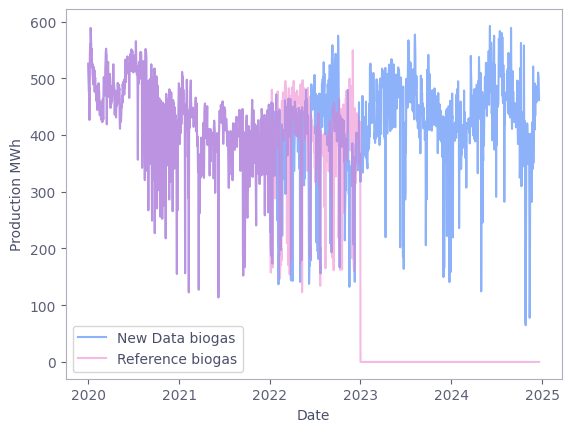

In [27]:
column_name = "biogas"
series_1 = new_data[column_name]
series_2 = reference_data[column_name]
plot_series_comparasion(series_1=series_1, series_2=series_2, comp_name=column_name, save_fig=True)

#### Check date integrity

In [28]:
demand_check_summary = check_time_series(demand, date_col="fecha_opreal", hour_col="hora_opreal")

Complete: No missing dates found in the range 2015-04-01 to 2025-04-01.

Found hour inconsistencies:
  - invalid_hours: 9 instances found
  - days_with_missing_hours: 8 instances found


There is 9 values for 25, that is inconsistent with the 24 hours at the day. Also, the hour 1 have 8 values less than the others, this could be because of hour changes in Chile. So a possible approach could be convert these nine 25 values to 1 instead.

In [29]:
temp_df = historic_tipo

In [30]:
production_check_summary = check_time_series(temp_df, hour_col="hora_opreal")

Complete: No missing dates found in the range 2020-01-01 to 2025-04-25.

Found hour inconsistencies:
  - invalid_hours: 6 instances found
  - days_with_missing_hours: 5 instances found


In [31]:
# Convert hour outliers (25 hour to 1)
demand_processed = demand[demand["hora_opreal"] != 24]
historic_tipo_processed = historic_tipo[historic_tipo["hora_opreal"] != 24]

# NOTE: actually the hour is the hour_real - 1 for datetime consistency, but could change 
demand_processed['datetime'] = demand_processed.apply(lambda row: row['fecha_opreal'].replace(hour=int(row['hora_opreal'])), axis=1)
historic_tipo_processed['datetime'] = historic_tipo_processed.apply(lambda row: row['fecha_opreal'].replace(hour=int(row['hora_opreal'])), axis=1)

/tmp/ipykernel_19933/1812538498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_processed['datetime'] = demand_processed.apply(lambda row: row['fecha_opreal'].replace(hour=int(row['hora_opreal'])), axis=1)
/tmp/ipykernel_19933/1812538498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic_tipo_processed['datetime'] = historic_tipo_processed.apply(lambda row: row['fecha_opreal'].replace(hour=int(row['hora_opreal'])), axis=1)


### Data Wrangling

In [32]:
start_date = "2024-01-01"
end_date = "2024-12-20"

demand_ranged = filter_by_date_range(demand_processed, "fecha_opreal", start_date, end_date)
generation_ranged = filter_by_date_range(historic_tipo_processed, "fecha_opreal", start_date, end_date)

In [33]:
# granularity = ["fecha_opreal", "hora_opreal"]
# energy_sources = raw_hourly_data["central_tipo_nemotecnico"].unique()

# demand_grouped = demand_ranged.groupby(by=granularity)[["demand"]].sum().reset_index()
# generation_grouped = generation_ranged.groupby(by=[*granularity, "central_tipo_nemotecnico", "subtipo_nemotecnico"])[["generacion_real_mwh"]].sum().reset_index()


In [34]:
merged = demand_ranged.merge(generation_ranged, how="inner", on=["fecha_opreal", "hora_opreal"])

In [35]:
merged["ernc"] = merged["solar"] + merged["eolica"] + merged["geotermica"]

### Find common frequencies

In [36]:
def analyze_periodogram(
    time_series: pd.Series,
    fs: float = 1.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
    """Compute the periodogram of a time series.

    Parameters:
    - time_series: pandas Series with the time series data.
    - fs: sampling frequency. For example, if the time series is hourly data
            and fs=1.0, frequencies will be in cycles/hour and periods in hours.
            If data is daily and fs=1.0, freq is in cycles/day, period in days.

    Returns:
    - frequencies: array of frequencies (excluding DC component).
    - spectrum: array of power spectral density (excluding DC component).
    - periods: array of periods corresponding to the frequencies.
    - top_periods_info: dictionary with the most significant periods and their power.
    """
    # Remove NaN values if any
    time_series_cleaned = time_series.dropna()

    # Detrend the data to remove linear trends (optional)
    # data_to_analyze = detrend(time_series_cleaned.values)
    data_to_analyze = time_series_cleaned.values

    # Compute the periodogram
    frequencies, spectrum = periodogram(data_to_analyze, fs=fs)

    # Skip the DC component (zero frequency)
    frequencies = frequencies[1:]
    spectrum = spectrum[1:]

    # Convert frequencies to periods
    # Ensure no division by zero if any frequency is zero (already handled by [1:])
    periods = 1 / frequencies

    # Sort periods by their power
    sorted_indices = np.argsort(spectrum)[::-1]
    top_periods_info = {}

    # Get the top 5 periods
    for i in range(min(5, len(sorted_indices))):
        idx = sorted_indices[i]
        period_val = periods[idx]
        power = spectrum[idx]

        # Convert period to a more readable format (hours, days, weeks, months, years)
        # This assumes the base unit of 'period_val' is hours (when fs is samples/hour)
        # If fs implies a different time unit for period_val, adjust accordingly.
        # For fs=1 (samples/hour) with hourly data:
        if period_val < 24:
            period_str = f"{period_val:.2f} hours"
        elif period_val < 24 * 7:
            period_str = f"{period_val / 24:.2f} days"
        elif period_val < 24 * 30:  # Approx. month
            period_str = f"{period_val / (24 * 7):.2f} weeks"
        elif period_val < 24 * 365:  # Approx. year
            period_str = f"{period_val / (24 * 30):.2f} months"
        else:
            period_str = f"{period_val / (24 * 365):.2f} years"

        top_periods_info[period_str] = {"period_value": period_val, "power": power}

    return frequencies, spectrum, periods, top_periods_info

In [37]:
frequencies, spectrum, periods, top_periods = analyze_periodogram(historic["eolica"], fs=1)

NameError: name 'historic' is not defined

In [ ]:
top_periods

{'24.00 hours': {'period_value': np.float64(23.999485066941297),
  'power': np.float64(1706787765.1682732)},
 '5.32 years': {'period_value': np.float64(46607.0),
  'power': np.float64(1491797048.6172717)},
 '2.66 years': {'period_value': np.float64(23303.5),
  'power': np.float64(685488273.7310791)},
 '23.94 hours': {'period_value': np.float64(23.937853107344633),
  'power': np.float64(321465334.18096215)},
 '12.00 hours': {'period_value': np.float64(11.999742533470648),
  'power': np.float64(273803954.09492344)}}

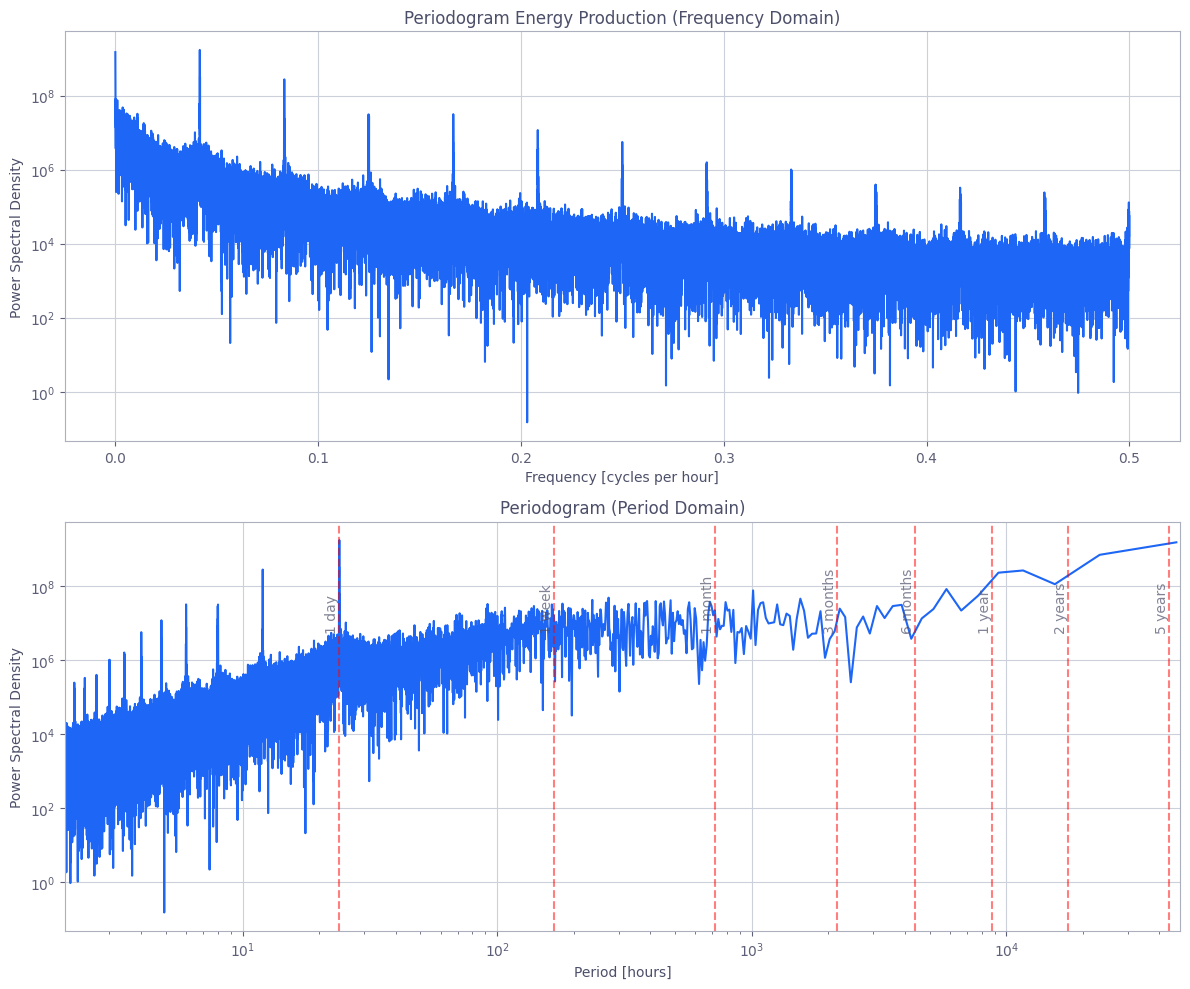

Top significant periods:
- 24.00 hours (value: 24.00 hours) with power 1.71e+09
- 5.32 years (value: 46607.00 hours) with power 1.49e+09
- 2.66 years (value: 23303.50 hours) with power 6.85e+08
- 23.94 hours (value: 23.94 hours) with power 3.21e+08
- 12.00 hours (value: 12.00 hours) with power 2.74e+08


In [ ]:
plot_periodogram(
    frequencies,
    spectrum,
    periods,
    top_periods,
    fs_unit="hour",
    title="Periodogram Energy Production",
)

## Visualization

### Gross time series

In [38]:
# temp_df = merged.groupby([merged['datetime'].dt.date, "central_tipo_nemotecnico"])['generacion_real_mwh'].sum().reset_index()

In [39]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 16), sharex=True)
# fig, ax1 = plt.subplots(figsize=(30, 8))

# # Plot the lineplot on the first subplot
# sns.lineplot(
#     temp_df,
#     x="datetime",
#     y="generacion_real_mwh",
#     hue="central_tipo_nemotecnico",
#     ax=ax1,
# )
# ax1.set_xlabel("Datetime")
# ax1.set_ylabel("Generation (MWh)")
# ax1.set_title("Energy Generation by Type")
# ax1.legend(loc="upper right")
# ax1.grid(True)

# Plot the stackplot on the second subplot
# ax2.stackplot(
#     pivot_generation["datetime"].dt.date,
#     pivot_generation["eolica"],
#     pivot_generation["geotermica"],
#     pivot_generation["hidraulica"],
#     pivot_generation["solar"],
#     pivot_generation["termica"],
#     labels=["Eolica", "Geotermica", "Hidraulica", "Solar", "Termica"],
#     alpha=0.6,
# )
# ax2.set_xlabel("Datetime")
# ax2.set_ylabel("Generation (MWh)")
# ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
# ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Hourly variation

In [40]:
columns = ["eolica", "geotermica", "hidraulica", "solar", "termica"]
temp_df = historic_tipo_processed.groupby("hora_opreal")[columns].sum().reset_index()
temp_df_2 = pd.melt(
    historic_tipo_processed,
    id_vars=["hora_opreal"],
    value_vars=columns,
    var_name="central_tipo_nemotecnico",
    value_name="generacion_real_mwh",
)

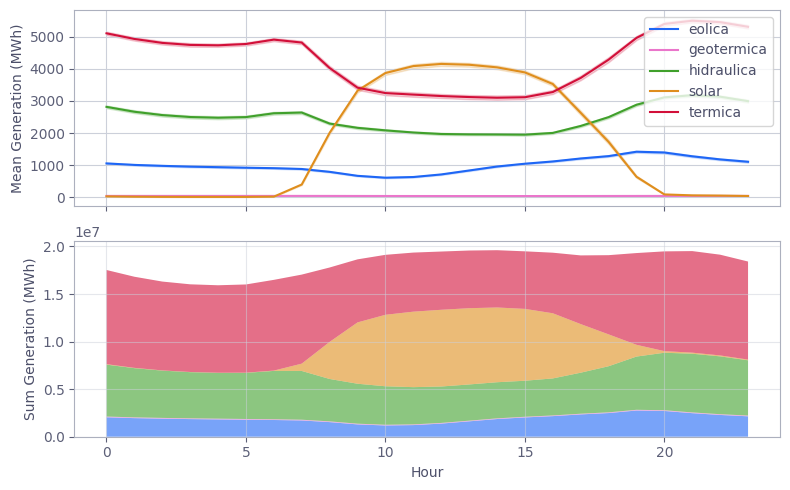

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# First subplot (lineplot)
sns.lineplot(
    data=temp_df_2,
    x="hora_opreal",
    y="generacion_real_mwh",
    hue="central_tipo_nemotecnico",
    ax=ax1,
)
ax1.set_xlabel("")
ax1.set_ylabel("Mean Generation (MWh)")
ax1.legend(loc="upper right")
ax1.grid(True)

# Second subplot (stackplot)
ax2.stackplot(
    temp_df["hora_opreal"],
    temp_df["eolica"],
    temp_df["geotermica"],
    temp_df["hidraulica"],
    temp_df["solar"],
    temp_df["termica"],
    labels=["Eoilica", "Geotermica", "Hidraulica", "Solar", "Hidraulica"],
    alpha=0.6,
)
ax2.set_xlabel("Hour")
ax2.set_ylabel("Sum Generation (MWh)")
ax2.grid(True, alpha=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

- Solar: Exhibits a distinct bell curve, peaking significantly during daylight hours (approximately 8 AM to 6 PM). Its generation is negligible during nighttime. This is characteristic of solar power.
- Eólica (Wind): Shows variability, with higher generation during early morning and late evening hours, and a dip during midday. This pattern can be influenced by typical wind patterns.
- Hidráulica (Hydroelectric): Maintains a relatively consistent and high level of generation throughout the day, with a slight decrease in the late evening. Hydroelectric power can often provide a stable baseload.
- Térmica (Thermal): Shows a gradual increase in generation from morning until evening, peaking in the later hours. This might indicate its use to meet peak demand or to compensate for the decline in solar power.
- Geotérmica (Geothermal): Provides a constant, low level of baseload generation throughout the day, as expected from geothermal source

### Boxplot by granularity

In [42]:
temp_df = pd.melt(
    historic_tipo_processed,
    id_vars=["datetime"],
    value_vars=columns,
    var_name="central_tipo_nemotecnico",
    value_name="generacion_real_mwh",
)

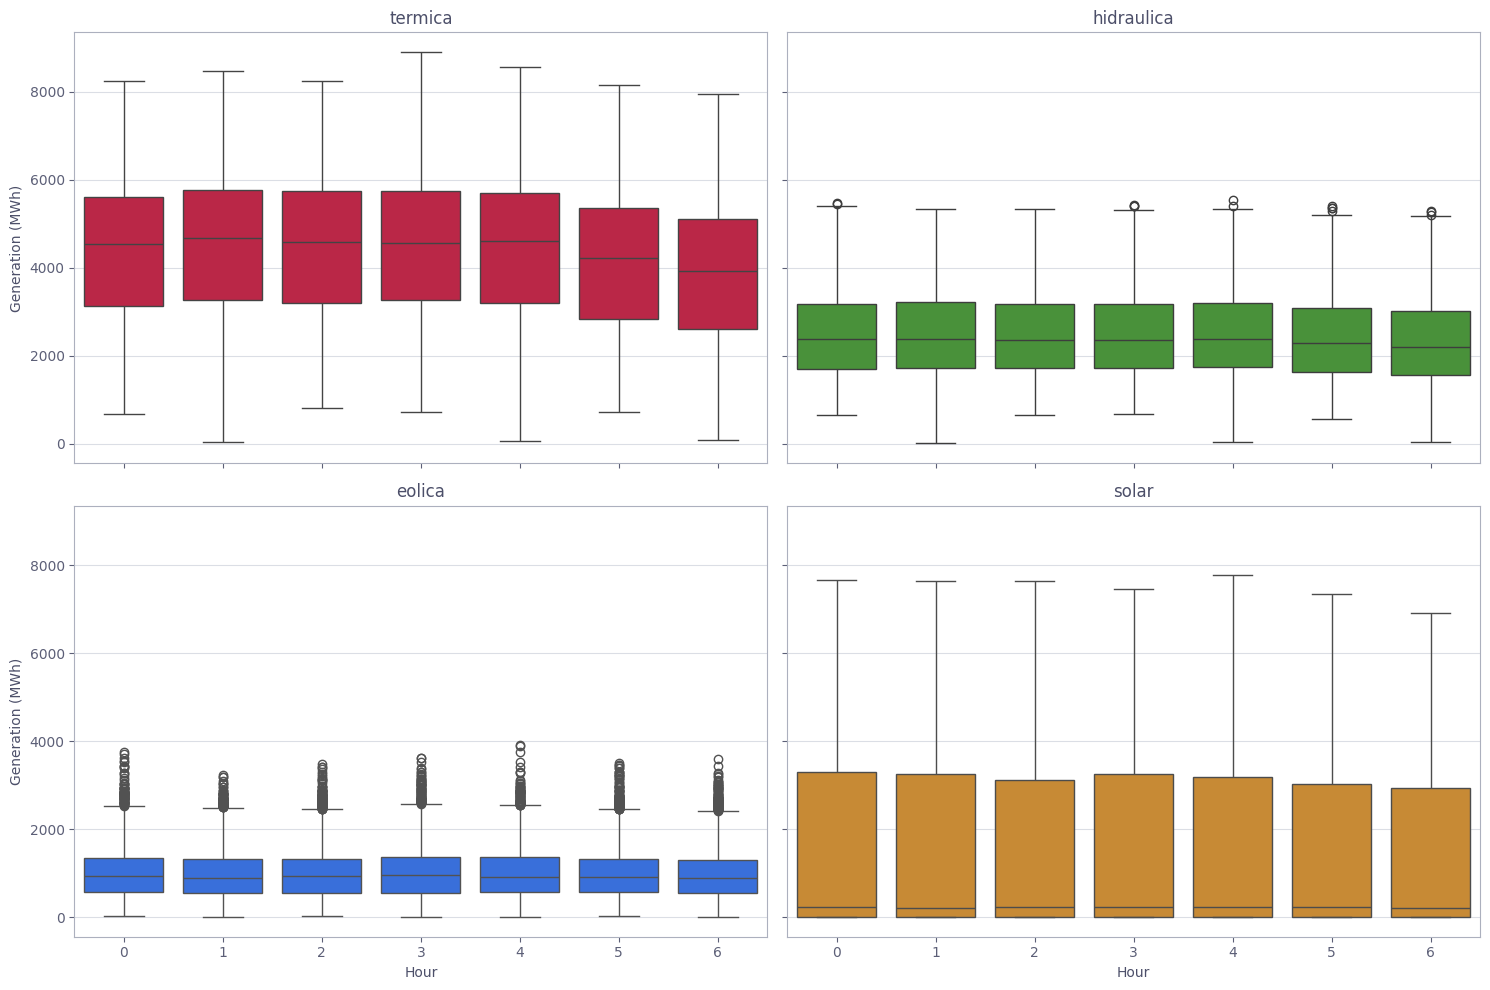

In [43]:
selected_types = ["termica", "hidraulica", "eolica", "solar"]

type_colors = {
    "termica": colors["red"],
    "hidraulica": colors["green"],
    "eolica": colors["blue"],
    "solar": colors["yellow"],
    "geotermica": colors["mauve"],
}

num_cols = 2
num_rows = (len(selected_types) + num_cols - 1) // num_cols

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True
)
axes = axes.flatten()

# Iterate through the selected types and create a boxplot for each
for i, category in enumerate(selected_types):
    if category in temp_df["central_tipo_nemotecnico"].unique():
        subset_df = temp_df[temp_df["central_tipo_nemotecnico"] == category]

        sns.boxplot(
            data=subset_df,
            y="generacion_real_mwh",
            x=subset_df["datetime"].dt.weekday,
            color=type_colors[category],
            ax=axes[i],
        )

        axes[i].set_title(f"{category}")
        axes[i].set_xlabel("Hour")
        axes[i].set_ylabel("Generation (MWh)")
        axes[i].grid(axis="y", alpha=0.7)
    else:
        # If the type is not found in the data, remove the corresponding subplot
        fig.delaxes(axes[i])

# Remove any remaining unused subplots
for j in range(len(selected_types), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [44]:
subset_df = temp_df[temp_df["central_tipo_nemotecnico"] == "solar"]
hourly_variance = subset_df.groupby(subset_df["datetime"].dt.hour)[
    "generacion_real_mwh"
].var()

In [45]:
round(hourly_variance)

datetime
0        2259.0
1        1119.0
2         747.0
3         662.0
4         692.0
5         672.0
6         867.0
7      144758.0
8      920627.0
9     1456511.0
10    1846812.0
11    2003223.0
12    2021232.0
13    1938660.0
14    1814319.0
15    1706755.0
16    1768402.0
17    2728412.0
18    2541057.0
19     578310.0
20       8685.0
21       6069.0
22       5079.0
23       3674.0
Name: generacion_real_mwh, dtype: float64

### Correlation Heatmap

In [46]:
year_to_evaluate = 2024
start_date = f"{year_to_evaluate}-01-01"
end_date = f"{year_to_evaluate}-12-31"

temp_df = filter_by_date_range(historic_tipo_processed, "datetime", start_date, end_date)
temp_df = temp_df.drop(columns=["datetime", "fecha_opreal", "hora_opreal"])

Text(70.72222222222221, 0.5, '')

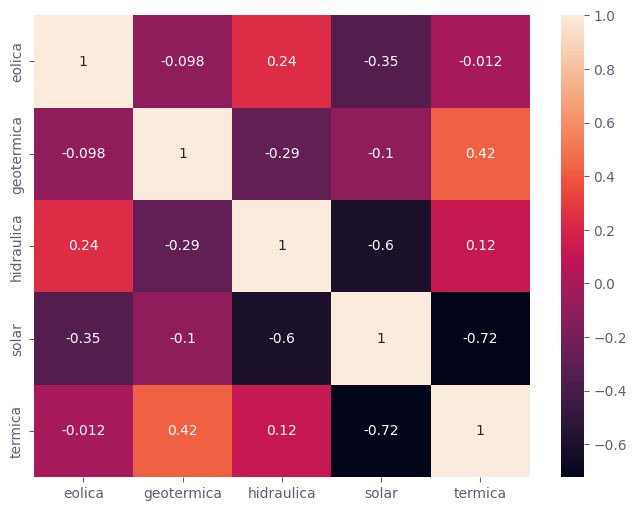

In [47]:
correlations_df = temp_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations_df, annot=True)

plt.xlabel("")
plt.ylabel("")
# plt.savefig(figures_path / f"correlations_{year_to_evaluate}.png")

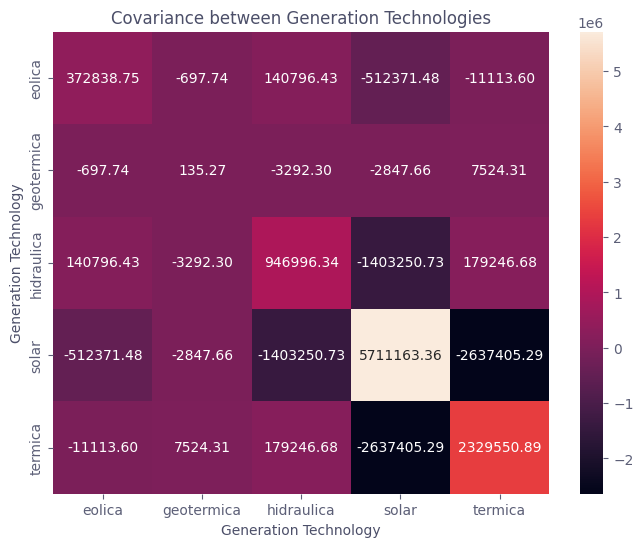

In [48]:
covariance_df = temp_df.cov()

# Plot the covariance matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    covariance_df,
    annot=True,
    fmt=".2f",
)  # Added cmap and fmt for better visualization

plt.xlabel("Generation Technology")
plt.ylabel("Generation Technology")
plt.title("Covariance between Generation Technologies")
plt.show()  # Added plt.show() to display the plot


### Daily variability across the year

In [49]:
# temp_df = historic_tipo_processed.copy()
# temp_df["month_name"] = temp_df["datetime"].dt.month_name()

In [50]:
# techs_type_color = {
#     "termica": colors["red"],
#     "hidraulica": colors["green"],
#     "eolica": colors["blue"],
#     "solar": colors["yellow"],
#     "geotermica": colors["mauve"],
# }

# for tech_name, color in techs_type_color.items():
#     print(tech_name, color)
#     ridgeline_plot = create_ridgeline_plot(
#         temp_df,
#         "month_name",
#         tech_name,
#         kde_color=color,
#         value_unit="kWh",
#         chronological_months=True,
#         title=f"Diary {tech_name} Generation Distribution (2024)",
#     )
    # plt.savefig(figures_path / f"2024_{tech_name}_diary_generation_distribution.png")

### Weather

In [51]:
temp_df = historic_tipo_processed.groupby("fecha_opreal")["eolica"].sum().reset_index()

In [52]:
precipitations["fecha_opreal"] = pd.to_datetime(precipitations["Date"], format="%d-%m-%y")
daylight_time["fecha_opreal"] = pd.to_datetime(daylight_time["Date"], format="%d-%m-%y")

In [69]:
# windspeed = windspeed[windspeed["ISO3"] == "CHL"]
# windspeed["fecha_opreal"] = pd.to_datetime(daylight_time["Date"], format="%Y-%m-%d")
daylight_time.head()

,Country,Territory,Unit,Daylightdaily,Date,fecha_opreal
0,CHL,Chile,minutes per day,897.818970,01-01-00,2000-01-01
1,CHL,Chile,minutes per day,897.257935,01-01-01,2001-01-01
2,CHL,Chile,minutes per day,897.450439,01-01-02,2002-01-01
3,CHL,Chile,minutes per day,897.638489,01-01-03,2003-01-01
4,CHL,Chile,minutes per day,897.821289,01-01-04,2004-01-01


In [54]:
merged = precipitations[["Precipitationdaily", "fecha_opreal"]].merge(historic_tipo_processed, on="fecha_opreal", how="inner")

In [55]:
merged["Precipitationdaily"].corr(merged["hidraulica"])

np.float64(-0.02758271764118239)

In [66]:
def plot_technologies(
    df: pd.DataFrame,
    tech_dict: dict[str, str],
    x_column="fecha_opreal",
    figsize=(16, 6),
    title="Historic total generation",
    xlabel="Datetime",
    ylabel="Generation (MWh)",
    save_fig: bool = False,
) -> None:
    """Create a figure with multiple rows, one for each technology type."""
    # Create subplots based on number of technologies
    n_techs = len(tech_dict)
    fig, axs = plt.subplots(
        n_techs,
        1,
        figsize=(figsize[0], figsize[1] * n_techs),
        sharex=True,
        constrained_layout=True,
    )

    # If only one technology, make axs a list for consistent indexing
    if n_techs == 1:
        axs = [axs]

    # Plot each technology in its own subplot
    for i, (tech_name, tech_info) in enumerate(tech_dict.items()):
        sns.lineplot(
            df,
            x=x_column,
            y=tech_info["column"],
            ax=axs[i],
            alpha=0.8,
            label=tech_name,
            color=tech_info["color"],
        )

        axs[i].set_ylabel(ylabel)
        axs[i].set_title(f"{tech_name} {ylabel}")
        axs[i].legend(loc="upper right")
        axs[i].grid(True)

    # Set the x-label only for the bottom subplot
    axs[-1].set_xlabel(xlabel)

    # Set the overall title
    fig.suptitle(title, fontsize=16)

    if save_fig:
        plt.savefig(figures_path / f"historic_{tech_dict.keys()}.png")

    return fig, axs

(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Hidraulica Generation (MWh)'}, xlabel='fecha_opreal', ylabel='Generation (MWh)'>,
        <Axes: title={'center': 'Precipitationdaily Generation (MWh)'}, xlabel='Datetime', ylabel='Generation (MWh)'>],
       dtype=object))

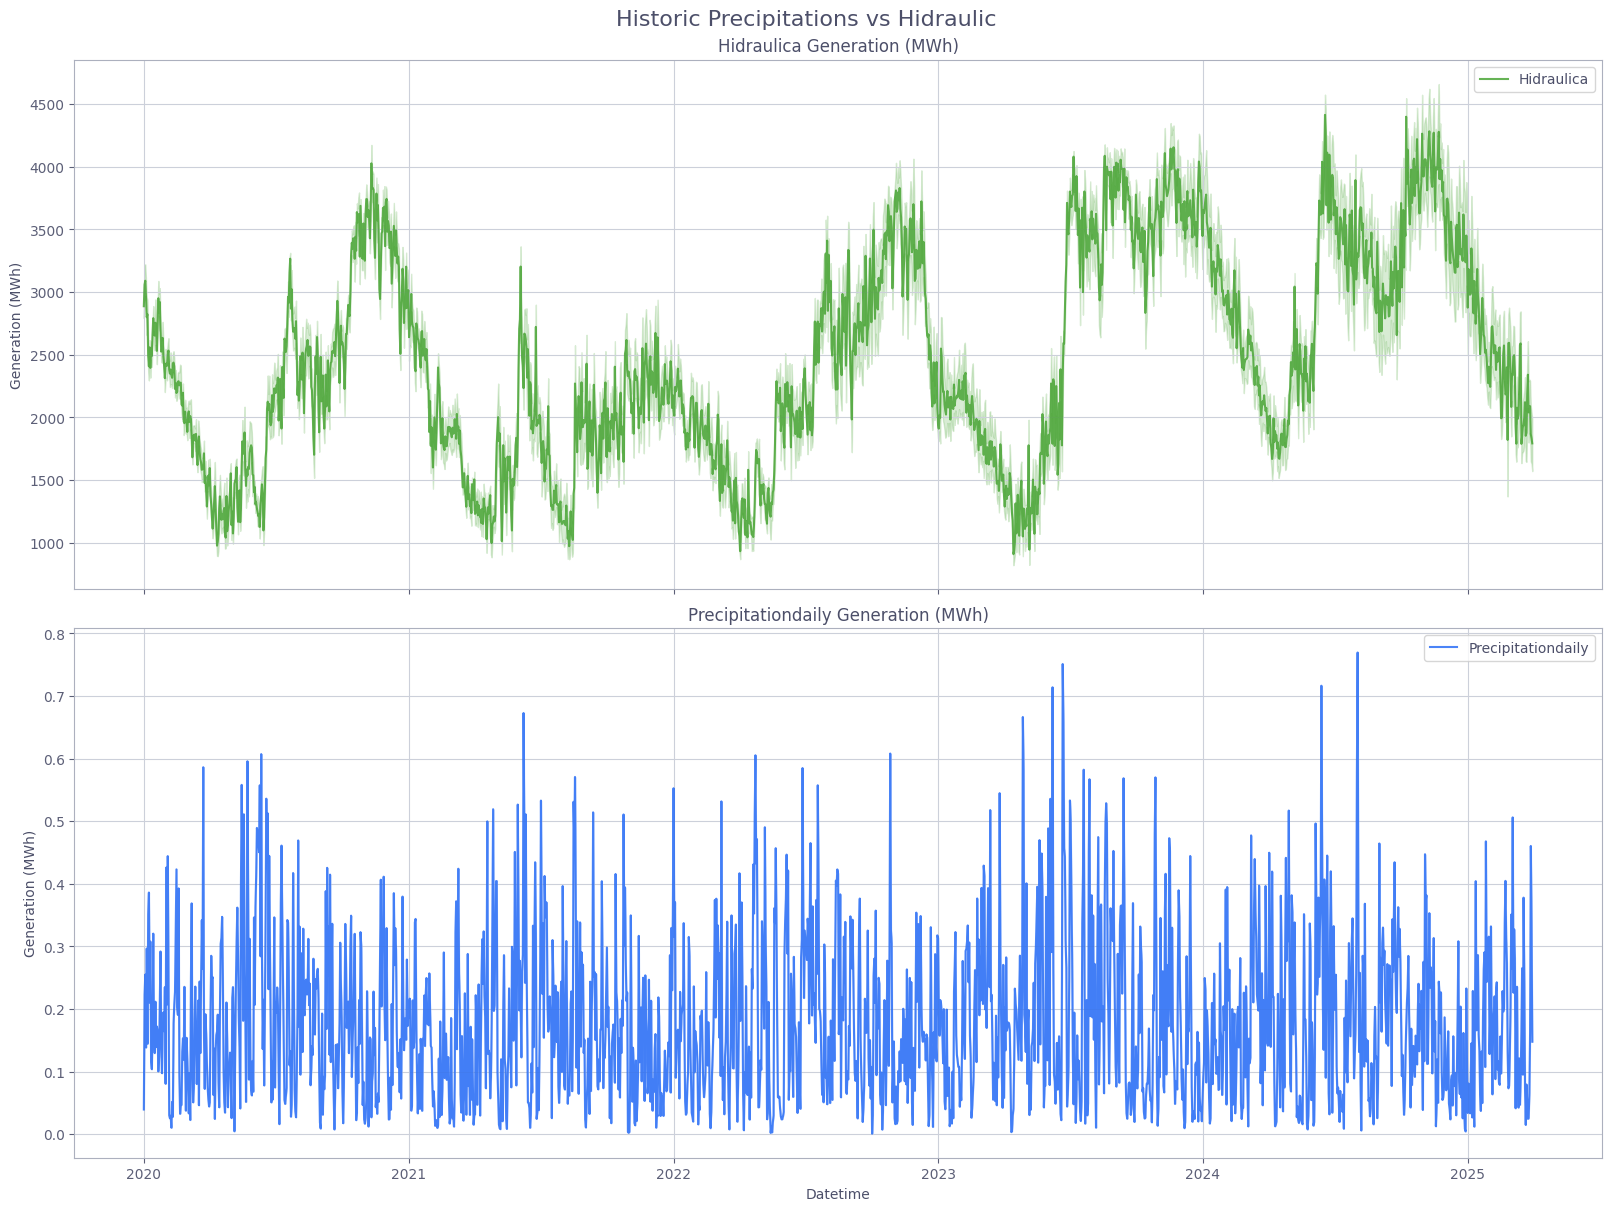

In [67]:
tech_dict = {
    "Hidraulica": {"column": "hidraulica", "color": colors["green"]},
    "Precipitationdaily": {"column": "Precipitationdaily", "color": colors["blue"]},
    # "Termica": {"column": "termica", "color": colors["red"]},
}

plot_technologies(df=merged, tech_dict=tech_dict, title="Historic Precipitations vs Hidraulic")